In [1]:
import apgpy as apg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Generate some data

In [2]:
n = 1000
d = 250
mu = 0.1
x_n = -0.1 * np.random.rand(d)
x_p = 0.1 * np.random.rand(d)
X_p = 5 * np.random.randn(d, n) + np.tile(x_p, (n, 1)).T
X_n = 5 * np.random.randn(d, n) + np.tile(x_n, (n, 1)).T
X = np.hstack((X_p, -X_n))

Define gradient operator

In [3]:
def log_reg_grad(y):
    v = np.exp(-np.dot(X.T, y))
    return np.dot(X, 1 / (1 + v) / 2 / n)

Define proximal operator

In [4]:
def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t * mu, 0)

Solve!

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.40e-01
iter num 34, norm(Gk)/(1+norm(xk)): 4.47e-13, step-size: 7.60e-02
terminated


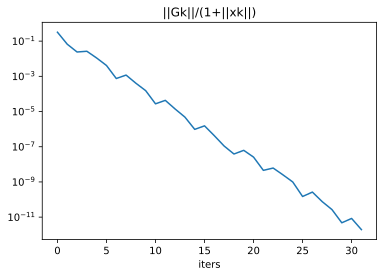

In [5]:
x = apg.solve(log_reg_grad, soft_thresh, np.zeros(d), eps = 1e-12, gen_plots=True)

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.40e-01
iter num 40, norm(Gk)/(1+norm(xk)): 6.56e-13, step-size: 9.47e-02
terminated


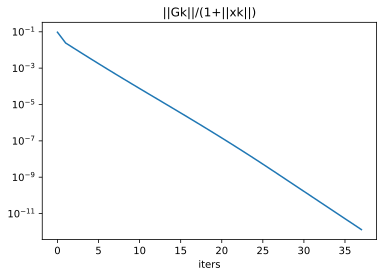

In [6]:
x_no_accleration = apg.solve(log_reg_grad, soft_thresh, np.zeros(d), use_gra=True, eps = 1e-12, gen_plots=True)

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.40e-01
iter num 71, norm(Gk)/(1+norm(xk)): 8.42e-13, step-size: 9.42e-02
terminated


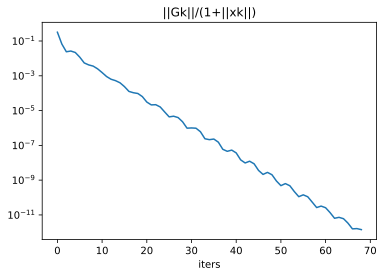

In [7]:
x_no_restart = apg.solve(log_reg_grad, soft_thresh, np.zeros(d), use_restart = False, eps = 1e-12, gen_plots=True)

Compare to ECOS (second order solver) and SCS (another first-order solver):

In [8]:
import cvxpy as cp

print(sum(cp.log_sum_exp(cp.vstack([0, np.dot(X[:, i].T, x)])).value for i in range(2 * n)) / 2 / n + mu * cp.norm(x, 1).value)

z = cp.Variable(d)
objective = cp.Minimize(sum(cp.log_sum_exp(cp.vstack([0, X[:, i].T@z])) for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1))
p = cp.Problem(objective)

p.solve(verbose=True, solver=cp.ECOS)  # not very accurate for some reason
print(sum(cp.log_sum_exp(cp.vstack([0, X[:, i].T@z])).value for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1).value)
z_ecos = z.value

p.solve(verbose=True, solver=cp.SCS, use_indirect=True)
print(sum(cp.log_sum_exp(cp.vstack([0, X[:, i].T@z])).value for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1).value)
z_scs = z.value


0.69187140400119

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.831e+03  +1e+04  6e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.385e+01  -1.110e+03  +6e+03  2e-01  1e+00  4e-01  4e-01  0.6266  8e-02   0  1  1 |  2  2
 2  +1.400e+01  -3.758e+02  +2e+03  5e-02  5e-01  2e-01  2e-01  0.6266  8e-02   0  0  0 |  1  2
 3  +8.236e+00  -1.111e+02  +1e+03  1e-02  3e-01  9e-02  7e-02  0.6266  5e-02   0  0  0 |  0  2
 4  +4.093e+00  -2.038e+01  +2e+02  2e-03  2e-01  2e-02  2e-02  0.7607  1e-02   0  0  0 |  0  1
 5  +3.078e+00  -7.153e+00  +1e+02  1e-03  1e-01  9e-03  7e-03  0.5811  4e-02   0  0  0 |  1  2
 6  +2.181e+00  -2.310e-01  +3e+01  2e-04  4e-02  2e-03  2e-03  0.7450  3e-02   0  0  0 |  0  1
 7  +1.454e+00  +4.105e-01  +2e+01  1e-04  1e-02  1e-03  1e-03  0.5013  1e-01   0  1  1 |  0  3
 8  +8.644e-01  +6.441e-01  +

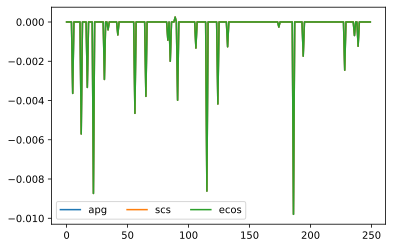

In [9]:
plt.plot(x, label='apg')
plt.plot(z_scs, label='scs')
plt.plot(z_ecos, label='ecos')
plt.legend(ncol=3)

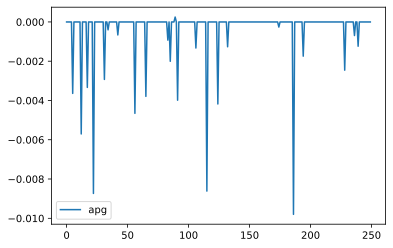

In [10]:
plt.plot(x, label='apg')
plt.legend()

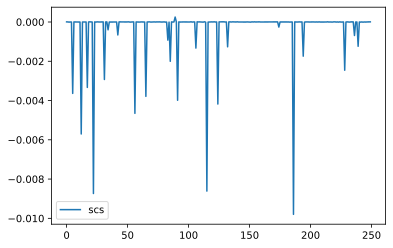

In [11]:
plt.plot(z_scs, label='scs')
plt.legend()

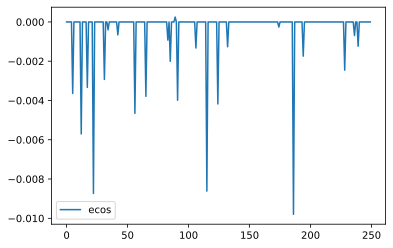

In [12]:
plt.plot(z_ecos, label='ecos')
plt.legend()